In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Introduction

The Lotka-Volterra population model is a system of differential equations used to model predator-prey relationships in nature. The basic feature of the model is the periodic relationship between the two populations as they compete to reproduce and survive. In this project I present a discrete cellular automata which approximately obeys the Lotka-Volterra equations and show why this relationship exists based on the design of the model. Furthermore I (will) estimate the model parameters using statistical methods.

# Methods

The environment of the cellular automata is represented by a square matrix with integer entries, and each position on this matrix is called a cell. The value of the matrix at a given cell's position is referred to as the cell's state. Although many commonly studied cellular automata allow for only finitely many states, our model allows each cell to take any of infinitely many integer values. Every cell is classified into one of three species: prey, predator, or empty. Any cell with positive state is prey, while any cell with negative state is predator. If the state is zero, the cell is empty. The prey population is defined as the sum of states over all prey cells, and the predator population is the absolute value of the sum of states over all predator cells.

The system evolves by a stochastic evolution function which depends on the position of each cell and three parameters describing the reproductive rates of each species. While it is possible define this function in terms of the cellular automata as described, this system has an equivalent formulation which makes the transition function more natural. Instead of defining prey and predator cells, we may define prey and predator organisms as elements of the following sets:
$$\texttt{Prey}=\{X_1,X_2,X_3,\dots,X_m\},\quad\texttt{Pred}=\{Y_1,Y_2,Y_3,\dots,Y_n\}$$
Each organism has a position on the square matrix, and two distinct organisms of the same species may share a position. At each time step, the motion of an invididual cell is given by a random walk with each step chosen uniformly from $\{-1,0,+1\}^2$. The steps are taken $\bmod N$ in each coordinate, and as a result the system environment is topologically equivalent to a torus.



$\text{$\textbf{Algorithm 1:}$ State transition function}$  

$\text{$\textbf{Input:}$ State variable $(\texttt{Prey},\texttt{Pred})$ and model parameters}$  
$\text{$\textbf{Output:}$ Updated state variable}$  

$01:\text{$\textbf{for each }X\in\texttt{Prey}\textbf{ do}$}$  
$02:\quad\text{Move $X$ by random step}$  
$03:\quad\text{$\textbf{if }\texttt{prey$_\texttt{grow}$}<\texttt{sample}[0,1]$$\textbf{ then}$}$  
$05:\quad\quad\text{Generate new prey at the position of }X$  
$06:$  
$07:\text{$\textbf{for each }Y\in\texttt{Pred}\textbf{ do}$}$  
$08:\quad\text{$\textbf{if }\texttt{pred$_\texttt{death}$}<\texttt{sample}[0,1]$$\textbf{ then}$}$  
$09:\quad\quad\text{Remove }Y\text{ from the system}$  
$10:\quad\text{$\textbf{else}$}$  
$11:\quad\quad\text{Move $Y$ by random step}$  
$12:\quad\quad\textbf{for each }X\in\texttt{Prey}\textbf{ do}$  
$12:\quad\quad\quad\textbf{if }X\text{ and }Y\text{ have same position}\textbf{ then}$  
$13:\quad\quad\quad\quad\text{Remove }X\text{ from the system}$  
$14:\quad\quad\quad\quad\text{$\textbf{if }\texttt{pred$_\texttt{grow}$}<\texttt{sample}[0,1]$$\textbf{ then}$}$  
$15:\quad\quad\quad\quad\quad\text{Generate new predator at the position of }Y$  

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

def iterate(Grid, state, params):
	
	dim = Grid.shape
	(prey_growthrate, pred_growthrate, pred_deathrate) = params
	(prey, pred) = state
	(prey_Grid, pred_Grid) = (np.zeros(dim), np.zeros(dim))
	
	# Step 1: Each prey moves randomly and may reproduce.
	for (index, cell) in np.ndenumerate(Grid):
		if cell > 0:
			for i in range(int(cell)):
				step = np.random.randint(-1, 2, size = np.size(dim))
				index_next = tuple((index + step) % dim)
				prey_Grid[index_next] += 1
				if np.random.random() < prey_growthrate:
					prey_Grid[index_next] += 1
					prey += 1

	# Step 2: Each predator either dies or moves randomly. If destination contains prey, then predator may reproduce.
	for (index, cell) in np.ndenumerate(Grid):
		if cell < 0:
			for i in range(int(-cell)):
				if np.random.random() < pred_deathrate:
					pred -= 1
				else:
					step = np.random.randint(-1, 2, size = np.size(dim))
					index_next = tuple((index + step) % dim)
					pred_Grid[index_next] += -1
					if prey_Grid[index_next] > 0:
						for j in range(int(prey_Grid[index_next])):
							if np.random.random() < pred_growthrate:
								pred_Grid[index_next] += -1
								pred += 1
						prey -= prey_Grid[index_next]
						prey_Grid[index_next] = 0
	
	Grid_next = prey_Grid + pred_Grid
	state_next = (prey, pred)
	return (Grid_next, state_next)

def Grid_init(dim, state_init):

	Grid = np.zeros(dim)
	(prey_init, pred_init) = state_init
	(prey, pred) = (0, 0)
	
	while prey < prey_init:
		index = tuple(np.random.randint(0, np.prod(dim), size = np.size(dim)) % dim)
		Grid[index] += 1
		prey += 1
	while pred < pred_init:
		index = tuple(np.random.randint(0, np.prod(dim), size = np.size(dim)) % dim)
		if Grid[index] <= 0:
			Grid[index] += -1 
			pred += 1
			
	return Grid

def compute_Orbit(dim, params, state_init, duration, trial = 0, trials = 1):
	Orbit = [state_init]
	Grid = Grid_init(dim, state_init)
	state = state_init
	
	for i in range(duration):
		(Grid, state) = iterate(Grid, state, params)
		Orbit.append(state)
		if 0 in state or sum(state) > np.prod(dim):
			return Orbit
	
	return Orbit

# Results


LVCA done


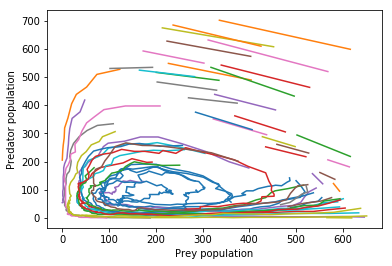

In [21]:
def LVCA(dim, params, trials, duration, prey_domain = (0, 1), pred_domain = (0, 1)):
	
	for trial in range(trials):
		state_init = (np.prod(dim)*np.random.uniform(*np.transpose([prey_domain, pred_domain]))).astype(int)
		Orbit = compute_Orbit(dim, params, state_init, duration, trial, trials)

		plt.plot(*np.transpose(Orbit))

	print('\nLVCA done')
	plt.xlabel('Prey population')
	plt.ylabel('Predator population')
	plt.show()
	return

dim = (25, 25)
prey_growthrate = .1
pred_growthrate = .5
pred_deathrate = .1
params = (prey_growthrate, pred_growthrate, pred_deathrate)
LVCA(dim, params, trials = 50, duration = 250)